<a href="https://colab.research.google.com/github/Andrian0s/ML4NLP1-2024-Tutorial-Notebooks/blob/main/tutorials_notebooks_in_class_2024/W13_Topic_Modeling_CTMs.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In this tutorial, we will go through Combined Topic Models (CTMs) - which utilizes contextualized embeddings from a Language Model alongside Bag of Words for extracting topics

`Combined = Concat(Contextualize,BoW)`

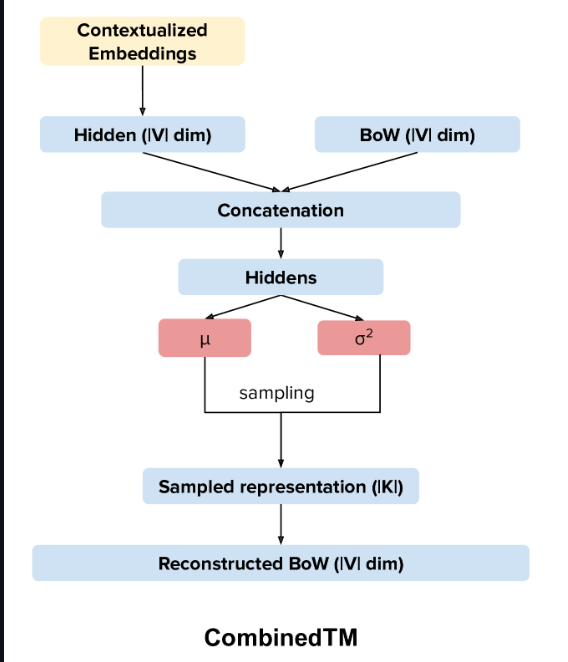

📝❓ How does an Autoencoder work?

📝❓ How does a Variational Autoencoder (VAE) work?

📝❓ Why do we use a VAE for Topic Modeling?

Now we look into Contextualized Topic Models, which uses pre-trained Document representation instead of a plain Bag of Words.

Method developed by [Bianchi et al. 2021](https://aclanthology.org/2021.acl-short.96/).

[A 6min presentation of the paper by one of the authors.](https://underline.io/lecture/25716-pre-training-is-a-hot-topic-contextualized-document-embeddings-improve-topic-coherence)

[Medium Blog](https://towardsdatascience.com/contextualized-topic-modeling-with-python-eacl2021-eacf6dfa576)

Code: [https://github.com/MilaNLProc/contextualized-topic-models](https://github.com/MilaNLProc/contextualized-topic-models)

Tutorial: [https://colab.research.google.com/drive/1fXJjr_rwqvpp1IdNQ4dxqN4Dp88cxO97?usp=sharing](https://colab.research.google.com/drive/1fXJjr_rwqvpp1IdNQ4dxqN4Dp88cxO97?usp=sharing)


In [1]:
!pip install -qU contextualized-topic-models pyldavis

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 24.0/24.0 MB 82.3 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 784.3/784.3 kB 51.1 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 121.6/121.6 kB 11.1 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 2.6/2.6 MB 88.2 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 1.6/1.6 MB 69.9 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 1.6/1.6 MB 70.0 MB/s eta 0:00:00
ERROR: pip's dependency resolver does not currently take into account all the packages that are installed. This behaviour is the source of the following dependency conflicts.
bigframes 1.27.0 requires ipywidgets>=7.7.1, but you have ipywidgets 7.5.1 which is incompatible.
bigquery-magics 0.4.0 requires ipywidgets>=7.7.1, but you have ipywidgets 7.5.1 which is incompatible.
google-colab 1.0.0 requires ipython==7.34.0, but you have ipython 8.10.0 which is incompatible.
ipyevents 2.0.2 requires ipywidgets>=7.6.0, but you have

### Import Necessary Libraries

In [2]:
import kagglehub
import pandas as pd
import os
from contextualized_topic_models.models.ctm import CombinedTM
from contextualized_topic_models.utils.data_preparation import TopicModelDataPreparation
from nltk.corpus import stopwords as stop_words
import nltk
nltk.download('stopwords')
import re

# Seed
import random
import numpy as np
random.seed(42)
np.random.seed(42)

[nltk_data] Downloading package stopwords to /root/nltk_data...
[nltk_data]   Unzipping corpora/stopwords.zip.


***Important - Executing the import below (WhiteSpacePreprocessing) will produce an error on the first run. Executing it again mitigates the error. This is probably due to some caching issues with contextualized_topic_models package***

In [3]:
from contextualized_topic_models.utils.preprocessing import WhiteSpacePreprocessing

ImportError: cannot import name 'triu' from 'scipy.linalg.special_matrices' (/usr/local/lib/python3.10/dist-packages/scipy/linalg/special_matrices.py)

In [4]:
from contextualized_topic_models.utils.preprocessing import WhiteSpacePreprocessing

In [5]:
from contextualized_topic_models.utils.preprocessing import WhiteSpacePreprocessingStopwords

### Download Dataset

In [6]:
# Download latest version
path = kagglehub.dataset_download("therohk/million-headlines")
df = pd.read_csv(os.path.join(path, 'abcnews-date-text.csv'))

# Inspect Dataset
print(df['headline_text'].iloc[0])

# Select only 100000 samples
df = df.sample(n=100000, random_state=42)
df.head()

100%|██████████| 21.4M/21.4M [00:00<00:00, 53.3MB/s]

Extracting files...


aba decides against community broadcasting licence


,publish_date,headline_text
1144371,20181017,virtual reality trial ahead of fire season in ...
282871,20070131,farmers prepare for ec funding
895099,20140810,the sunday inquisition august 10
764744,20130221,news csg reax
894276,20140806,rosetta spacecraft on final approach to comet ...


### Preprocess

We need preprocessed text for Bag of Words - so the vocabulary space does not explode, and unpreprocessed text for getting embeddings from Language Model as they provide better context  

In [7]:
# Take only 10k samples for faster training
documents = df['headline_text'].apply(lambda line: line.strip()).tolist()[:10000]
stopwords = list(stop_words.words("english"))

sp = WhiteSpacePreprocessingStopwords(documents, stopwords_list=stopwords)
preprocessed_documents, unpreprocessed_corpus, vocab, retained_indices = sp.preprocess()

In [8]:
# Take a look at the preprocessed documents

preprocessed_documents[:5]

['reality trial ahead fire season south australia',
 'farmers prepare funding',
 'sunday august',
 'news csg',
 'final approach']

### Training

Here we use [all-mpnet-base-v2](https://huggingface.co/sentence-transformers/all-mpnet-base-v2) model which embeds sentences & paragraphs to a 768 dimensional dense vector space


In [9]:
# Prepare dataset for training - passing both preprocessed data for contextual representation and unpreprocessed data for bow
tp = TopicModelDataPreparation("all-mpnet-base-v2")
training_dataset = tp.fit(text_for_contextual=unpreprocessed_corpus, text_for_bow=preprocessed_documents)
# Check Vocab
tp.vocab[:10]

/usr/local/lib/python3.10/dist-packages/huggingface_hub/utils/_auth.py:94: UserWarning: 
The secret `HF_TOKEN` does not exist in your Colab secrets.
To authenticate with the Hugging Face Hub, create a token in your settings tab (https://huggingface.co/settings/tokens), set it as secret in your Google Colab and restart your session.
You will be able to reuse this secret in all of your notebooks.
Please note that authentication is recommended but still optional to access public models or datasets.
  warnings.warn(


modules.json:   0%|          | 0.00/349 [00:00<?, ?B/s]

config_sentence_transformers.json:   0%|          | 0.00/116 [00:00<?, ?B/s]

README.md:   0%|          | 0.00/10.6k [00:00<?, ?B/s]

sentence_bert_config.json:   0%|          | 0.00/53.0 [00:00<?, ?B/s]

config.json:   0%|          | 0.00/571 [00:00<?, ?B/s]

model.safetensors:   0%|          | 0.00/438M [00:00<?, ?B/s]

tokenizer_config.json:   0%|          | 0.00/363 [00:00<?, ?B/s]

vocab.txt:   0%|          | 0.00/232k [00:00<?, ?B/s]

tokenizer.json:   0%|          | 0.00/466k [00:00<?, ?B/s]

special_tokens_map.json:   0%|          | 0.00/239 [00:00<?, ?B/s]

1_Pooling/config.json:   0%|          | 0.00/190 [00:00<?, ?B/s]

Batches:   0%|          | 0/50 [00:00<?, ?it/s]

array(['abattoir', 'abbott', 'abc', 'aboriginal', 'abuse', 'academic',
       'accc', 'access', 'accident', 'accused'], dtype=object)

In [10]:
'''
bow_size = vocab_size
contextual_size = embedding dimension
n_components = number of topics
num_epochs = epochs for training
'''
ctm = CombinedTM(bow_size=len(tp.vocab), contextual_size=768, n_components=5, num_epochs=10)
ctm.fit(training_dataset) # run the model

Epoch: [10/10]	 Seen Samples: [97920/98240]	Train Loss: 28.539230708203284	Time: 0:00:02.615590: : 10it [00:26,  2.65s/it]
100%|██████████| 154/154 [00:02<00:00, 73.61it/s]


### Get Topic Lists

In [11]:
# Look at the top 10 words in each topic  - We had 5 topics
ctm.get_topic_lists(10)

[['charged',
  'man',
  'crash',
  'death',
  'trial',
  'cup',
  'day',
  'woman',
  'guilty',
  'murder'],
 ['fire',
  'coast',
  'house',
  'gold',
  'residents',
  'labor',
  'queensland',
  'nsw',
  'still',
  'warning'],
 ['interview',
  'abc',
  'energy',
  'news',
  'market',
  'climate',
  'carbon',
  'business',
  'mining',
  'future'],
 ['govt',
  'police',
  'wa',
  'school',
  'health',
  'new',
  'urged',
  'sa',
  'urges',
  'indigenous'],
 ['china',
  'australian',
  'team',
  'sea',
  'wool',
  'war',
  'syria',
  'finals',
  'donald',
  'win']]

### Visualizing the topics

In [12]:
import pyLDAvis as vis

In [13]:
lda_vis_data = ctm.get_ldavis_data_format(tp.vocab, training_dataset, n_samples=10)

ctm_pd = vis.prepare(**lda_vis_data)
vis.display(ctm_pd)

/usr/local/lib/python3.10/dist-packages/ipykernel/ipkernel.py:283: DeprecationWarning: `should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.
  and should_run_async(code)
100%|██████████| 154/154 [00:02<00:00, 73.33it/s]


📝❓ Can you guess the topics?

📝❓ Is it more coherent than LDA?


## Multilingual Setting

Here, we will use [polynews](https://huggingface.co/datasets/aiana94/polynews) dataset - consisting of news headlines from 77 languages. We select the following languages - German (Script: Latin), Greek (Script: Greek) and Bengali (Script: Bengali) for analysis. German and Greek have a decent dataset size. However, Bengali has only ~2K samples.  

### Download Dataset

In [14]:
# Get De dataset
df_de = pd.read_parquet("hf://datasets/aiana94/polynews/data/deu_Latn/train.parquet.gzip")
df_de['lang'] = ['de']*df_de.shape[0]
print(df_de.shape)
df_de.head()

/usr/local/lib/python3.10/dist-packages/ipykernel/ipkernel.py:283: DeprecationWarning: `should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.
  and should_run_async(code)


(145484, 3)


,text,provenance,lang
0,BBC erklärt eigenen Beitrag über Entschädigung...,wikinews,de
1,SS-Lagerkommandant Schwammberger gestorben,wikinews,de
2,Verkauf von Telefonen mit voreingestellter Tel...,wikinews,de
3,Vorabversion von Thunderbird 1.0 freigegeben,wikinews,de
4,Neue Dinosaurierart in Brasilien entdeckt,wikinews,de


In [15]:
# Get Greek dataset
df_greek = pd.read_parquet("hf://datasets/aiana94/polynews/data/ell_Grek/train.parquet.gzip")
df_greek['lang'] = ['greek'] * df_greek.shape[0]
print(df_greek.shape)
df_greek.head()

/usr/local/lib/python3.10/dist-packages/ipykernel/ipkernel.py:283: DeprecationWarning: `should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.
  and should_run_async(code)


(50176, 3)


,text,provenance,lang
0,15 άνθρωποι σκοτώθηκαν στις Φιλιππίνες μετά απ...,wikinews,greek
1,17 νεκροί μετά από έκρηξη βόμβας σε λουτρό στο...,wikinews,greek
2,2 Μετάλλια για την ενόργανη γυμναστική στο Ευρ...,wikinews,greek
3,38 νεκροί μετά από επίθεση σε τράπεζα του Αφγα...,wikinews,greek
4,4 νεκροί σε διαδηλώσεις στη Συρία,wikinews,greek


In [16]:
# Get Bengali dataset
df_ben = pd.read_parquet("hf://datasets/aiana94/polynews/data/ben_Beng/train.parquet.gzip")
df_ben['lang'] = ['ben'] * df_ben.shape[0]
print(df_ben.shape)
df_ben.head()

/usr/local/lib/python3.10/dist-packages/ipykernel/ipkernel.py:283: DeprecationWarning: `should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.
  and should_run_async(code)


(2268, 3)


,text,provenance,lang
0,৩০০: একটি চলচিত্রের চেয়েও বেশী অনেক ইরানীর জন্যে,globalvoices,ben
1,কিন্তু এর বদলে আমরা পাচ্ছি ‘অংশগ্রহনের শুন্যতা...,globalvoices,ben
2,‘রাইজিং ভয়েসেস’ এর লক্ষ্য হচ্ছে নতুন নতুন কমিউ...,globalvoices,ben
3,× আমাদের নতুন মিডিয়া (new media) কারিকুলাম স্ব...,globalvoices,ben
4,"সম্পুর্ন আবেদনপত্র শুক্রবার, ১৫ই জুনের মধ্যে o...",globalvoices,ben


In [17]:
# Select 2,268 Samples from each of the dataset - to make our dataset balanced
df_de_sampled = df_de.sample(n=df_ben.shape[0], random_state=42)
df_greek_sampled = df_greek.sample(n=df_ben.shape[0], random_state=42)
# Concatenate and Shuffle
df = pd.concat([df_de_sampled, df_greek_sampled, df_ben])
df = df.sample(frac=1, random_state=42)
print(df.shape)
# Check distribution of languages
print(df[['text','lang']].groupby(by='lang').count())
# Inspect first 10 rows
df.head(10)

(6804, 3)
       text
lang       
ben    2268
de     2268
greek  2268


/usr/local/lib/python3.10/dist-packages/ipykernel/ipkernel.py:283: DeprecationWarning: `should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.
  and should_run_async(code)


,text,provenance,lang
8479,@AlyaaGad: Μην αφήσετε ελεύθερο τον Κλούνεϊ.,globalvoices,greek
41836,"""Μετά τη σύλληψή του, ο Bosančić αρνήθηκε ότι ...",globalvoices,greek
8474,Από την ιστοσελίδα της Maya Pedal:,globalvoices,greek
46874,"Το πρώτο βίντεο τραβήχτηκε από τον Ferwierna, ...",globalvoices,greek
12640,"Κίνα: Πρωτάθλημα για την Li Na, Εθνική Υπερηφά...",globalvoices,greek
17915,Το e-book αυτό προορίζεται να αποτελέσει χρήσι...,globalvoices,greek
117006,"""Der israelische linksorientierte Aktivist Joh...",globalvoices,de
1467,ছবি www. erki. nl এর সৌজন্যে,globalvoices,ben
136563,"Zuvor hatten beide Parteien eingewilligt, den ...",globalvoices,de
38769,"""""""Αισθάνομαι έτσι επειδή είμαι άνθρωπος"""", λέ...",globalvoices,greek


### Preprocess

In [18]:
# Lets look at languages supported by NLTK for stopwords
# Bengali, German and Greek are present!
# 29 languages supported
from nltk.corpus import stopwords
print(stopwords.fileids())
print(len(stopwords.fileids()))

['arabic', 'azerbaijani', 'basque', 'bengali', 'catalan', 'chinese', 'danish', 'dutch', 'english', 'finnish', 'french', 'german', 'greek', 'hebrew', 'hinglish', 'hungarian', 'indonesian', 'italian', 'kazakh', 'nepali', 'norwegian', 'portuguese', 'romanian', 'russian', 'slovene', 'spanish', 'swedish', 'tajik', 'turkish']
29


/usr/local/lib/python3.10/dist-packages/ipykernel/ipkernel.py:283: DeprecationWarning: `should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.
  and should_run_async(code)


In [19]:
# There might be cases where english or words from other language appear in the text. We need to remove them (example - www.erki.nl, twiiter)
from nltk.corpus import words
import re
nltk.download('words')
# Load the set of English words
english_vocab = set(words.words()).union(set(['facebook','twitter','flickr']))


/usr/local/lib/python3.10/dist-packages/ipykernel/ipkernel.py:283: DeprecationWarning: `should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.
  and should_run_async(code)
[nltk_data] Downloading package words to /root/nltk_data...
[nltk_data]   Unzipping corpora/words.zip.


In [20]:
def remove_english_words(text):
    tokenized_words = re.findall(r'\b\w+\b', text) # Tokenize the words
    non_english = [word for word in tokenized_words if word.lower() not in english_vocab]
    return ' '.join(non_english)

df['text'] = df['text'].apply(lambda x: remove_english_words(x))

/usr/local/lib/python3.10/dist-packages/ipykernel/ipkernel.py:283: DeprecationWarning: `should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.
  and should_run_async(code)


In [21]:
count = 0
for w in english_vocab:
    print(w)
    count += 1
    if count==10:
        break

alismaceous
porule
nonsympathy
tenuiroster
dermestoid
discretiveness
sireship
trembling
devolvement
spurrer


/usr/local/lib/python3.10/dist-packages/ipykernel/ipkernel.py:283: DeprecationWarning: `should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.
  and should_run_async(code)


In [22]:
df.head(10)

/usr/local/lib/python3.10/dist-packages/ipykernel/ipkernel.py:283: DeprecationWarning: `should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.
  and should_run_async(code)


,text,provenance,lang
8479,AlyaaGad Μην αφήσετε ελεύθερο τον Κλούνεϊ,globalvoices,greek
41836,Μετά τη σύλληψή του ο Bosančić αρνήθηκε ότι χρ...,globalvoices,greek
8474,Από την ιστοσελίδα της,globalvoices,greek
46874,Το πρώτο βίντεο τραβήχτηκε από τον Ferwierna μ...,globalvoices,greek
12640,Κίνα Πρωτάθλημα για την Εθνική Υπερηφάνεια,globalvoices,greek
17915,Το αυτό προορίζεται να αποτελέσει χρήσιμο εργα...,globalvoices,greek
117006,Der israelische linksorientierte Aktivist John...,globalvoices,de
1467,ছব www erki nl এর স জন য,globalvoices,ben
136563,Zuvor hatten beide Parteien eingewilligt Anfor...,globalvoices,de
38769,Αισθάνομαι έτσι επειδή είμαι άνθρωπος λέει ο H...,globalvoices,greek


In [23]:
# Combine all stopwords
documents = df['text'].apply(lambda line: line.strip()).tolist()
stopwords_de = list(stop_words.words("german"))
stopwords_greek = list(stop_words.words("greek"))
stopwords_ben = list(stop_words.words("bengali"))
stopwords = stopwords_de + stopwords_greek + stopwords_ben

# Remove Stopwords
sp = WhiteSpacePreprocessingStopwords(documents, stopwords_list=stopwords)
preprocessed_documents, unpreprocessed_corpus, vocab, retained_indices = sp.preprocess()

/usr/local/lib/python3.10/dist-packages/ipykernel/ipkernel.py:283: DeprecationWarning: `should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.
  and should_run_async(code)


In [24]:
# Take a look at the preprocessed documents
preprocessed_documents[:5]

/usr/local/lib/python3.10/dist-packages/ipykernel/ipkernel.py:283: DeprecationWarning: `should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.
  and should_run_async(code)


['τη συλληψη χρησιμοποιησε οταν αρχες στοιχεια εκανε',
 'ιστοσελιδα της',
 'πρωτο βιντεο ελεγχο της',
 'κινα εθνικη',
 'συζητηση']

### Training

Here we use [paraphrase-multilingual-mpnet-base-v2](https://huggingface.co/sentence-transformers/paraphrase-multilingual-mpnet-base-v2) model, a multilingual sentence transformer model trained on 50+ languages

In [25]:
# Prepare dataset for training - passing both preprocessed data for contextual representation and unpreprocessed data for bow
tp = TopicModelDataPreparation("sentence-transformers/paraphrase-multilingual-mpnet-base-v2")
training_dataset = tp.fit(text_for_contextual=unpreprocessed_corpus, text_for_bow=preprocessed_documents)
# Check Vocab
tp.vocab[:10]

/usr/local/lib/python3.10/dist-packages/ipykernel/ipkernel.py:283: DeprecationWarning: `should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.
  and should_run_async(code)


modules.json:   0%|          | 0.00/229 [00:00<?, ?B/s]

config_sentence_transformers.json:   0%|          | 0.00/122 [00:00<?, ?B/s]

README.md:   0%|          | 0.00/4.13k [00:00<?, ?B/s]

sentence_bert_config.json:   0%|          | 0.00/53.0 [00:00<?, ?B/s]

config.json:   0%|          | 0.00/723 [00:00<?, ?B/s]

model.safetensors:   0%|          | 0.00/1.11G [00:00<?, ?B/s]

tokenizer_config.json:   0%|          | 0.00/402 [00:00<?, ?B/s]

sentencepiece.bpe.model:   0%|          | 0.00/5.07M [00:00<?, ?B/s]

tokenizer.json:   0%|          | 0.00/9.08M [00:00<?, ?B/s]

special_tokens_map.json:   0%|          | 0.00/239 [00:00<?, ?B/s]

1_Pooling/config.json:   0%|          | 0.00/190 [00:00<?, ?B/s]

/usr/local/lib/python3.10/dist-packages/contextualized_topic_models/utils/data_preparation.py:64: UserWarning: the longest document in your collection has 265 words, the model instead truncates to 128 tokens.
  warnings.warn(


Batches:   0%|          | 0/33 [00:00<?, ?it/s]

array(['ab', 'acht', 'afghanistan', 'afrikas', 'ahmad', 'ahmed',
       'aktivist', 'aktivisten', 'aktivitaten', 'alaa'], dtype=object)

In [26]:
ctm = CombinedTM(bow_size=len(tp.vocab), contextual_size=768, n_components=5, num_epochs=10)
ctm.fit(training_dataset) # run the model

/usr/local/lib/python3.10/dist-packages/ipykernel/ipkernel.py:283: DeprecationWarning: `should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.
  and should_run_async(code)
Epoch: [10/10]	 Seen Samples: [64640/65090]	Train Loss: 49.03248384683439	Time: 0:00:01.679923: : 10it [00:18,  1.87s/it]
100%|██████████| 102/102 [00:01<00:00, 68.20it/s]


In [27]:
# Look at the top 10 words in each topic  - We had 5 topics
ctm.get_topic_lists(10)

/usr/local/lib/python3.10/dist-packages/ipykernel/ipkernel.py:283: DeprecationWarning: `should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.
  and should_run_async(code)


[['fur',
  'uber',
  'দরক',
  'টবল',
  'wurde',
  'শরক',
  'krieg',
  'kam',
  'endlich',
  'konnen'],
 ['ενα',
  'ηταν',
  'τους',
  'της',
  'οποια',
  'τη',
  'διαρκεια',
  'μια',
  'ειχε',
  'επισης'],
 ['ηταν',
  'ενα',
  'τη',
  'της',
  'μια',
  'τους',
  'βιντεο',
  'διαρκεια',
  'εχουν',
  'επιθεση'],
 ['কর', 'ইট', 'একট', 'রক', 'ওয', 'সম', 'ইন', 'অন', 'হয', 'যবহ'],
 ['ছব', 'পড', 'ফত', 'nc', 'co', 'www', 'http', 'cc', 'আমর', 'yfrog']]

### Visalizing the topics

In [28]:
lda_vis_data = ctm.get_ldavis_data_format(tp.vocab, training_dataset, n_samples=10)

ctm_pd = vis.prepare(**lda_vis_data)
vis.display(ctm_pd)

/usr/local/lib/python3.10/dist-packages/ipykernel/ipkernel.py:283: DeprecationWarning: `should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.
  and should_run_async(code)
100%|██████████| 102/102 [00:01<00:00, 67.90it/s]


/usr/local/lib/python3.10/dist-packages/ipykernel/ipkernel.py:283: DeprecationWarning: `should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.
  and should_run_async(code)
